In [55]:
import numpy as np
import pandas as pd
import random
from typing import List, Dict, Any, Optional, Tuple
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [56]:
df = pd.read_csv('datasets_56102_107707_monthly-beer-production-in-austr.csv',
                 parse_dates=['Month'], index_col='Month')

In [57]:
def make_sliding_windows(series: np.ndarray, dates: np.ndarray, T: int):
    X, Y, Y_dates = [], [], []
    for t in range(T, len(series)):
        X.append(series[t-T:t])
        Y.append(series[t])
        Y_dates.append(dates[t])
    X = np.array(X).reshape(-1, T)
    Y = np.array(Y).reshape(-1)
    Y_dates = np.array(Y_dates)
    return X, Y, Y_dates

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return mae, rmse

def build_baseline_model(T: int, lr: float):
    i = Input(shape=(T,))
    x = Dense(1)(i)
    model = Model(i, x)
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    return model

def baseline_search(df: pd.DataFrame,
                    n_trials: int = 10,
                    epochs: int = 40,
                    early_stop: int = 8,
                    verbose: int = 1,
                    seed: int = 0
                   ) -> Tuple[List[Dict[str, Any]], Optional[Dict[str, Any]]]:
    
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

    colname = df.columns[0]
    series_vals = df[colname].values.astype(float)
    dates = df.index.to_numpy()

    # chronological 3-way split boundaries
    train_end = np.datetime64('1983-09-01')
    val_end = np.datetime64('1989-08-01')

    results: List[Dict[str, Any]] = []
    global_best_val = float('inf')
    best_record = None

    def sample_baseline_hyperparams():
        lr = 10 ** random.uniform(np.log10(1e-4), np.log10(5e-3))
        T = random.choice((6, 12, 24, 36))
        batch_size = random.choice((16, 32, 64, 128))
        return dict(lr=lr, T=T, batch_size=batch_size)

    for r in range(1, n_trials + 1):
        h = sample_baseline_hyperparams()
        T = h['T']
        batch_size = h['batch_size']
        lr = h['lr']

        X_all, Y_all, Y_dates = make_sliding_windows(series_vals, dates, T)

        train_idx = np.where(Y_dates <= train_end)[0]
        val_idx = np.where((Y_dates > train_end) & (Y_dates <= val_end))[0]
        test_idx = np.where(Y_dates > val_end)[0]

        X_train = X_all[train_idx]
        Y_train = Y_all[train_idx]

        X_val = X_all[val_idx]
        Y_val = Y_all[val_idx]

        X_test = X_all[test_idx]
        Y_test = Y_all[test_idx]
        dates_test = Y_dates[test_idx]

        # scalers fit on training only
        scaler_X = StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_s = scaler_X.transform(X_train.reshape(-1, 1)).reshape(-1, T)
        X_val_s = scaler_X.transform(X_val.reshape(-1, 1)).reshape(-1, T)
        X_test_s = scaler_X.transform(X_test.reshape(-1, 1)).reshape(-1, T)

        scaler_y = StandardScaler().fit(Y_train.reshape(-1, 1))
        Y_train_s = scaler_y.transform(Y_train.reshape(-1, 1)).reshape(-1)
        Y_val_s = scaler_y.transform(Y_val.reshape(-1, 1)).reshape(-1)
        Y_test_s = scaler_y.transform(Y_test.reshape(-1, 1)).reshape(-1)

        model = build_baseline_model(T=T, lr=lr)
        es = EarlyStopping(monitor='val_loss', patience=early_stop, restore_best_weights=True, verbose=0)

        fit_verbose = 0
        if verbose == 1:
            fit_verbose = 1
        elif verbose == 2:
            fit_verbose = 0

        history = model.fit(
            X_train_s, Y_train_s,
            validation_data=(X_val_s, Y_val_s),
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            callbacks=[es],
            verbose=fit_verbose
        )

        # best validation loss
        if 'val_loss' in history.history and len(history.history['val_loss']) > 0:
            best_val_loss = float(min(history.history['val_loss']))
        else:
            best_val_loss = float(model.evaluate(X_val_s, Y_val_s, verbose=0))

        # compute val predictions and metrics
        val_preds_scaled = model.predict(X_val_s, batch_size=batch_size, verbose=0).reshape(-1)
        val_preds_unscaled = scaler_y.inverse_transform(val_preds_scaled.reshape(-1,1)).reshape(-1)
        val_true_unscaled = scaler_y.inverse_transform(Y_val_s.reshape(-1,1)).reshape(-1)
        val_mae, val_rmse = compute_metrics(val_true_unscaled, val_preds_unscaled)

        # iterative test forecast using the chosen model
        h_len = len(Y_test)
        preds_scaled = []
        if X_val_s.shape[0] > 0:
            last_window = X_val_s[-1].copy()
        else:
            last_window = X_train_s[-1].copy()

        for _step in range(h_len):
            p_s = float(model.predict(last_window.reshape(1, -1), verbose=0)[0, 0])
            preds_scaled.append(p_s)
            last_window = np.roll(last_window, -1)
            last_window[-1] = p_s

        preds_scaled = np.array(preds_scaled)
        preds_unscaled = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(-1)
        test_true_unscaled = scaler_y.inverse_transform(Y_test_s.reshape(-1, 1)).reshape(-1)
        test_mae, test_rmse = compute_metrics(test_true_unscaled, preds_unscaled)

        results.append({
            'trial': r,
            'params': h,
            'val_loss_scaled': best_val_loss,
            'val_mae': float(val_mae),
            'val_rmse': float(val_rmse),
            'test_mae': float(test_mae),
            'test_rmse': float(test_rmse)
        })

        # pick best by validation loss
        if best_val_loss < global_best_val - 1e-12:
            global_best_val = best_val_loss
            best_record = {
                'trial': r,
                'params': h,
                'val_loss_scaled': best_val_loss,
                'scaler_X': scaler_X,
                'scaler_Y': scaler_y,
                'test_dates': pd.to_datetime(dates_test),
                'y_test_true': test_true_unscaled.copy(),
                'y_test_pred': preds_unscaled.copy(),
                'model_weights': model.get_weights(),
                'loss_history': {
                    'train': history.history.get('loss', []).copy(),
                    'val': history.history.get('val_loss', []).copy()
                },
                'test_mae': float(test_mae),
                'test_rmse': float(test_rmse)
            }

        if verbose == 1:
            print(f'trial {r}/{n_trials}: val_loss={best_val_loss:.6f} test_mae={test_mae:.3f} test_rmse={test_rmse:.3f}')
        elif verbose == 2:
            print(f'{r}/{n_trials}')

    return results, best_record


In [58]:

results, best = baseline_search(df, n_trials=30, epochs=40, early_stop=8, verbose=2, seed=0)

df_res = pd.DataFrame(results)
df_res_sorted = df_res.sort_values('val_loss_scaled')

top3_val = df_res_sorted.head(3)

print('Top 3 by validation loss:')
for _, row in top3_val.iterrows():
    print(f'trial {int(row['trial']):3d} | val_rmse={row['val_rmse']:.3f} | '
        f'val_loss={row['val_loss_scaled']:.6f} | params={row['params']}')

df_res_test_sorted = df_res.sort_values('test_rmse')
top3_test = df_res_test_sorted.head(3)

print('\nTop 3 by test RMSE:')
for _, row in top3_test.iterrows():
    print(f'trial {int(row['trial']):3d} | test_rmse={row['test_rmse']:.3f} | '
        f'val_loss={row['val_loss_scaled']:.6f} | params={row['params']}')

best_row = df_res_sorted.iloc[0]

print('\nBest model (selected by lowest validation loss)')
print(f'trial={int(best_row['trial'])} | val_loss={best_row['val_loss_scaled']:.6f} | '
      f'val_mae={best_row['val_mae']:.3f} | val_rmse={best_row['val_rmse']:.3f} | '
      f'test_mae={best_row['test_mae']:.3f} | test_rmse={best_row['test_rmse']:.3f}')
print(f'Params: {best_row['params']}')




1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30
Top 3 by validation loss:
trial   1 | val_rmse=14.257 | val_loss=0.183885 | params={'lr': np.float64(0.0027204916467565596), 'T': 36, 'batch_size': 16}
trial  10 | val_rmse=14.869 | val_loss=0.193024 | params={'lr': np.float64(0.002952130907972045), 'T': 24, 'batch_size': 16}
trial   2 | val_rmse=14.948 | val_loss=0.202145 | params={'lr': np.float64(0.00436813329131012), 'T': 36, 'batch_size': 128}

Top 3 by test RMSE:
trial  29 | test_rmse=22.106 | val_loss=0.268098 | params={'lr': np.float64(0.0015788461265690583), 'T': 24, 'batch_size': 32}
trial   1 | test_rmse=22.901 | val_loss=0.183885 | params={'lr': np.float64(0.0027204916467565596), 'T': 36, 'batch_size': 16}
trial  14 | test_rmse=27.457 | val_loss=0.299673 | params={'lr': np.float64(0.003012343636515037), 'T': 12, 'batch_size': 32}

Best model (selected by l

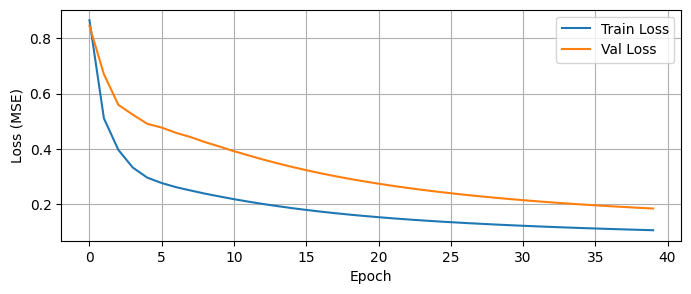

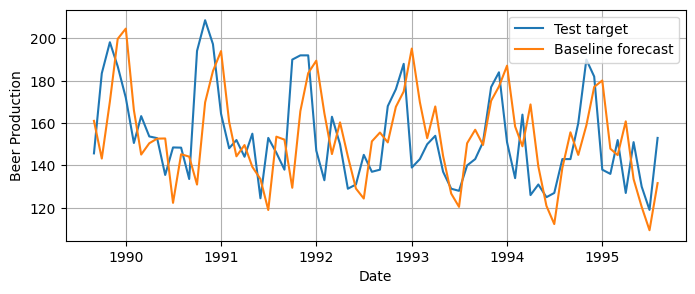

In [59]:
train_loss = best["loss_history"]["train"]
val_loss = best["loss_history"]["val"]

plt.figure(figsize=(8, 3))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

dates = best['test_dates']
true = best['y_test_true']
pred = best['y_test_pred']

plt.figure(figsize=(8, 3))
plt.plot(dates, true, label="Test target")
plt.plot(dates, pred, label="Baseline forecast")
plt.xlabel("Date")
plt.ylabel("Beer Production")
plt.legend()
plt.grid(True)
plt.show()
